In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

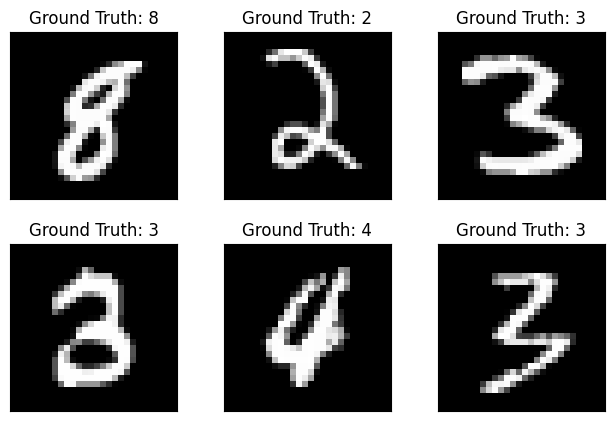

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
# print(example_targets)
# print(example_data.shape)
 
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
 
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
 
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(1, n_epochs + 1)]

In [ ]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')
 
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331576
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.314991
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.302986
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.277550
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.300649
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.276592
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.261338
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.262542
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.207763
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.121302
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.081775
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.136614
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.966252
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.998167
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.753186
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.827958
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.580517
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.560963
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.749973
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.347895
Train Epoch: 1 [12800/60000 (

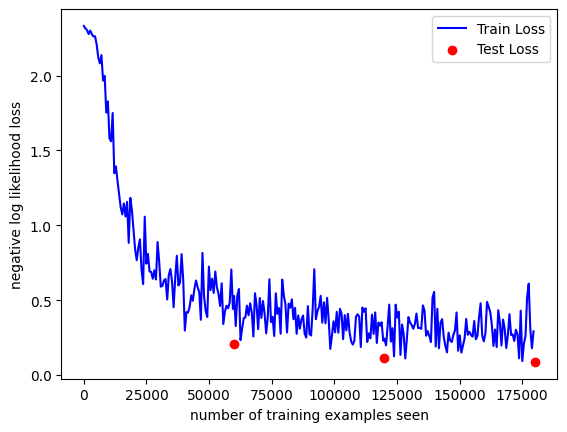

In [11]:
test_counter = [i * len(train_loader.dataset) for i in range(1, n_epochs + 1)]
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.savefig('Train_Test_Loss.png')

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.192295
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.209149
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.222094
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.352180
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.351793
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.159130
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.110570
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.233505
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.171062
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.227495
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.181837
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.181223
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.187806
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.429554
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.416051
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.265241
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.176434
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.362650
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.351908
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.321132
Train Epoch: 4 [12800/60000 (

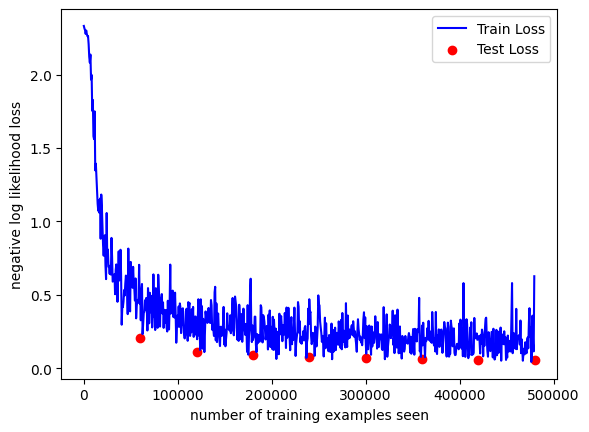

In [12]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
 
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)
optimizer_state_dict = torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)
 
for i in range(4, 9):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()
 
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.savefig('Train_Test_Loss_Continued.png')